In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from jax import random, nn
from jax import grad, value_and_grad
import jax
import jax.numpy as jnp

In [3]:
def neuron_initialization(architecture, seed = 42):
    
    params = {}
    
    key = random.PRNGKey(seed)
    for i in range(len(architecture)-1):
        
        inputs = architecture[i]
        oputs = architecture[i+1]
        
        initializer = jax.nn.initializers.he_normal()
        #initializer(subkey, (inputs, oputs), jnp.float32) 
        
        key, subkey = random.split(key)
        params[f'w_{i}'] = initializer(subkey, (inputs, oputs), jnp.float32)  #random.uniform(subkey, shape=(inputs, oputs), minval=-1, maxval= 1)     #Weights from neuron to neuron 
        key, subkey = random.split(key)
        params[f'b_{i}'] = initializer(subkey, (1, oputs), jnp.float32)  #random.uniform(subkey, shape=(1, oputs),  minval=-1, maxval= 1)           #Bais vecor for each layer
        
    return params

In [4]:
def forward_propagation(params, x_input):
    
    # could this be removed if we utilize back propagation using jax??
    a = x_input
    
    n_layers = int(len(params)/2)
    
    for i in range(n_layers):
        w = params[f'w_{i}']
        b = params[f'b_{i}']
        a_input = a
        
        z = a_input @ w + b
       
        if i < n_layers - 1:
            a = nn.relu(z)           #general simple activation function is used
        else: #problem specific case, for classification we do softmax
            a = nn.softmax(z)
                   
    return a

In [5]:
def cross_entropy_loss(params, x_input, y_labels, lamba_lasso = 0, lambda_ridge = 0):
    y_probs = forward_propagation(params, x_input)
    log_probs = jnp.log(y_probs) 
    one_hot_labels = nn.one_hot(y_labels, y_probs.shape[-1])  # Convert to one-hot encoding, and use the y_probes dims as the num of classes
    l = -jnp.mean(jnp.sum(one_hot_labels * log_probs, axis=1))
    
    if lamba_lasso != 0:
        l+= lamba_lasso*jnp.sum(jnp.array([jnp.sum(jnp.abs(params[f'w_{i}'])) for i in range(int(len(params) / 2))]))
    if lambda_ridge != 0:
        l+= lambda_ridge*jnp.sum(jnp.array([jnp.sum(params[f'w_{i}'] ** 2) for i in range(int(len(params) / 2))]))
          
    return l

In [6]:
def schuffel_data(x, y, seed):
    key = jax.random.PRNGKey(seed) 
    permutation = jax.random.permutation(key, x.shape[0])
    return x[permutation], y[permutation]

def batch_generator(x_input, y_target, batch_size, schuffel = True, seed = 42):
    
    n_batches = int(len(y_target)/batch_size)
        
    #x_batches = jnp.zeros(shape=(n_batches, batch_size, x_input.shape[1]))
    #y_batches = jnp.zeros(shape=(n_batches, batch_size))
    
    if schuffel:     
        x_input, y_target = schuffel_data(x_input, y_target, seed)
    
    for i in range(n_batches):
        
        #x_batches = x_batches.at[i].set(x_input[i*batch_size:(i+1)*batch_size,:])
        #y_batches = y_batches.at[i].set(y_target[i*batch_size:(i+1)*batch_size])

        x_batch = jnp.array(x_input[i*batch_size:(i+1)*batch_size,:])
        y_batch = jnp.array(y_target[i*batch_size:(i+1)*batch_size])
    
        yield x_batch, y_batch
    
    #return (x_batches, y_batches)

In [7]:
def gd_parameter_update(param_grad, params, alpha):
   
    #updating parameters
    updated_params = {}
    for param in params.keys():
        updated_params[param] = params[param] - alpha*param_grad[param]
    
    return updated_params

In [9]:
def standardize_data(x):

    
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_std = (x - mean)/(std + 0.0001)

    
    return x_std, mean, std

def data_split(x, y, split_coeff = 0.8):
    n_rows = x.shape[0]
    
    sc_size = int(split_coeff * n_rows)
    
    
    sc_x = x[:sc_size]
    sc_y = y[:sc_size]
    
    sc_inv_x = x[sc_size:]
    sc_inv_y = y[sc_size:]
    
    return sc_x, sc_y, sc_inv_x, sc_inv_y

def prepare_data(x_input, y_target, standerdize = True):


    x_train, y_train, x_test, y_test = data_split(x_input, y_target, 0.8)


    x_train_n, y_train_n, x_train_v, y_train_v = data_split(x_train, y_train, 0.8)


    if standerdize:
        
        #main traing data
        x_std_train, mean_train, std_train = standardize_data(x_train)
        x_train  = x_std_train
        x_test = (x_test - mean_train)/std_train
                
        #Validation
        x_std_train_n, mean_train_n, std_train_n = standardize_data(x_train_n)
        x_train_n = x_std_train_n
        x_train_v = (x_train_v - mean_train_n)/std_train_n

    return x_train, y_train, x_train_n, y_train_n, x_train_v, y_train_v, x_test, y_test
  


In [10]:
def predict(params, x):
    y_probs = forward_propagation(params, x)
    return np.argmax(y_probs, axis=1)

def accuracy(params, x_input, y_target):
    y_pred = predict(params, x_input)
    return np.mean(y_target == y_pred)

In [11]:
def mnist_data_load(percent = 1):
    
    train_df = pd.read_csv('../data/mnist_train.csv')
    test_df = pd.read_csv('../data/mnist_test.csv')
    
    all_data = pd.concat([train_df, test_df], ignore_index=True)
    
    n_points = len(all_data)
    
    cut_off_val = int(percent * n_points)
    
    x_df = all_data.drop('label', axis=1)
    y_df = all_data['label']
    
    x_input = x_df.to_numpy()
    y_target = y_df.to_numpy()
     
    return x_input[:cut_off_val], y_target[:cut_off_val]

In [12]:
from optimizers import adam_parameter_update

def classification_train_2(params, loss, x_input, y_target, batch_size=25, epochs=200, alpha=0.01,
                         optimizer="gd", lambda_lasso=0, lambda_ridge=0, beta1=0.9, beta2=0.999, eps=1e-8):
    
    history = {'loss_v_epoch': []}
    
    if optimizer == "adam":
        m = {key: jnp.zeros_like(value) for key, value in params.items()}
        v = {key: jnp.zeros_like(value) for key, value in params.items()}
        t = 1
    
    for i in range(epochs): 
        for x_i_batch, y_i_batch in batch_generator(x_input, y_target, batch_size, schuffel=True, seed=42):
            
            loss_i, param_grad = value_and_grad(loss, argnums=0)(params, x_i_batch, y_i_batch, lambda_lasso, lambda_ridge)
            
            if optimizer == "gd":
                params = gd_parameter_update(param_grad, params, alpha)
            elif optimizer == "adam":
                params, m, v = adam_parameter_update(param_grad, params, m, v, t, alpha, beta1, beta2, eps)
                t += 1
            else:
                raise ValueError(f"Optimizer '{optimizer}' !")
           
        history['loss_v_epoch'].append(loss_i)

        print(f'Epoch {i+1}/{epochs} -> Loss: {loss_i:.4f}')
            
    return params, history

In [13]:
import itertools
import jax.numpy as jnp
from sklearn.model_selection import KFold

def hyperparameter_search(params, architecture, data, labels, k_folds):
    alphas = [0.001]
    lasso_values = [0]
    ridge_values = [0.01] 
    batch_sizes = [256]
    epochs_values = [200, 250, 300]

    best_acc = 0
    best_params = {}

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for alpha, lambda_lasso, lambda_ridge, batch_size, epochs in itertools.product(alphas, lasso_values, ridge_values, batch_sizes, epochs_values):
        print(f"\nTesting con: alpha={alpha}, Lasso={lambda_lasso}, Ridge={lambda_ridge}, batch_size={batch_size}, epochs={epochs}")

        fold_accuracies = []
        
        for train_index, val_index in kf.split(data):
            train_data, val_data = data[train_index], data[val_index]
            train_labels, val_labels = labels[train_index], labels[val_index]
            
            params = neuron_initialization(architecture)

            trained_params, history = classification_train_2(
                params, cross_entropy_loss, train_data, train_labels,
                epochs=epochs, batch_size=batch_size, optimizer="adam",
                alpha=alpha, lambda_lasso=lambda_lasso, lambda_ridge=lambda_ridge
            )

            val_acc = accuracy(trained_params, val_data, val_labels)
            fold_accuracies.append(val_acc)

        avg_acc = jnp.mean(jnp.array(fold_accuracies))
        print(f"Average Validation Accuracy: {avg_acc:.4f}")

        if avg_acc > best_acc:
            best_acc = avg_acc
            best_params = {
                'alpha': alpha,
                'lambda_lasso': lambda_lasso,
                'lambda_ridge': lambda_ridge,
                'batch_size': batch_size,
                'epochs': epochs
            }

    print("\nBest combination:")
    print(f"alpha={best_params['alpha']}, lambda_lasso={best_params['lambda_lasso']}, lambda_ridge={best_params['lambda_ridge']}, batch_size={best_params['batch_size']}, epochs={best_params['epochs']}")
    print(f"Best Average Accuracy: {best_acc:.4f}")

    return best_params

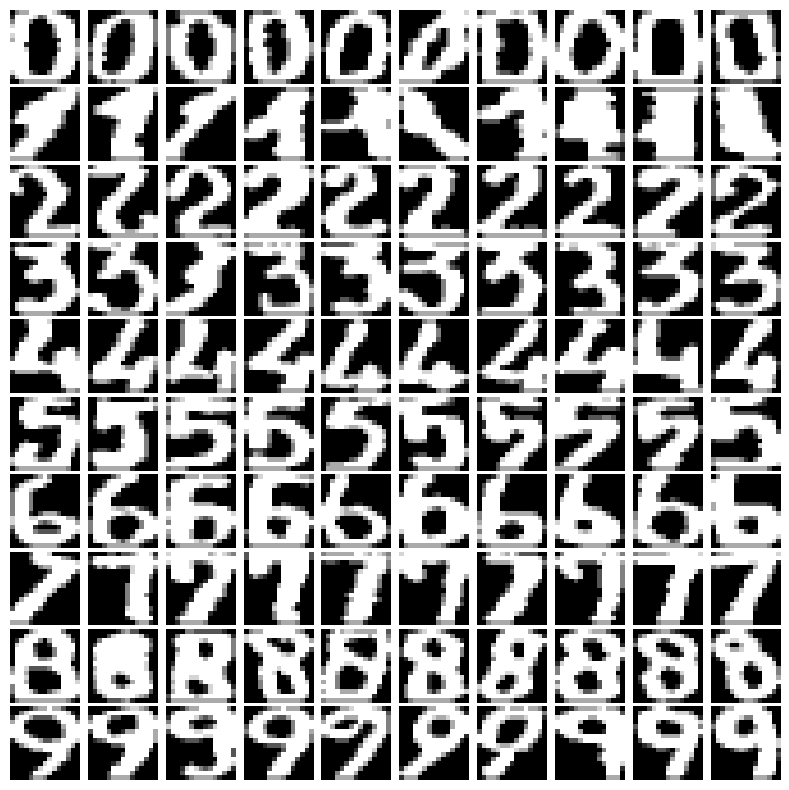

In [14]:
import preprocessing
import augmentation

dataset_path = "../data/mfeat-pix"

np.random.seed(42)

img_shape = (16, 15)

data = preprocessing.load_data(dataset_path)

num_classes = 10
samples_per_class = 200
train_samples_per_class = 100
test_samples_per_class = 100

train_data, test_data = preprocessing.split_data(data, num_classes, samples_per_class, train_samples_per_class)

import matplotlib.pyplot as plt

def plot_sample_images_by_class(data, num_classes=10, samples_per_class=10, img_shape=(16, 15), save_path="../visualizations/dataset_visualization.pdf"):
    """
    Plots a fixed number of sample images per class in a grid.
    """
    plt.figure(figsize=(samples_per_class, num_classes))  # Regola la dimensione della figura
    
    samples_per_class = min(samples_per_class, len(data) // num_classes)

    for class_idx in range(num_classes):
        start_idx = class_idx * (len(data) // num_classes)
        class_samples = data[start_idx : start_idx + samples_per_class]

        for i in range(samples_per_class):
            plt.subplot(num_classes, samples_per_class, class_idx * samples_per_class + i + 1)
            plt.imshow(class_samples[i].reshape(img_shape), cmap='gray')
            plt.axis('off')

    plt.subplots_adjust(hspace=0.05, wspace=0.05)  # Riduce lo spazio tra le immagini
    plt.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_sample_images_by_class(train_data, num_classes=10, samples_per_class=10, img_shape=img_shape)

In [15]:
import augmentation
import importlib
importlib.reload(augmentation)

augment_rotate = np.radians(12)

#augmentation.augment_data(train_data, img_shape, augment_rotate, num_versions=4)

train_data_aug = np.load("../augmented_datasets/augmented_data.npy")

In [17]:
train_labels, test_labels = preprocessing.create_labels(num_classes, train_samples_per_class=500, test_samples_per_class=100)
print(train_labels.shape)
print(test_labels.shape)


architecture = [train_data.shape[1], 64, 64, num_classes]

print(architecture)
params = neuron_initialization(architecture)

best_params = hyperparameter_search(params, architecture, train_data_aug, train_labels, k_folds=5)

(5000,)
(1000,)
[240, 64, 64, 10]

Testing con: alpha=0.001, Lasso=0, Ridge=0.01, batch_size=256, epochs=200
Epoch 1/200 -> Loss: 4.1434


KeyboardInterrupt: 

In [164]:
architecture = [train_data.shape[1], 64, 64, num_classes]

print(architecture)
params = neuron_initialization(architecture)

trained_params, history = classification_train_2(
                params, cross_entropy_loss, train_data_aug, train_labels,
                epochs=250, batch_size=256, optimizer="adam",
                alpha=0.001, lambda_ridge=0.01
            )

accuracy(trained_params, test_data, test_labels)

[240, 64, 64, 10]
Epoch 1/250 -> Loss: 3.8016
Epoch 2/250 -> Loss: 3.0095
Epoch 3/250 -> Loss: 2.6572
Epoch 4/250 -> Loss: 2.4318
Epoch 5/250 -> Loss: 2.2520
Epoch 6/250 -> Loss: 2.0992
Epoch 7/250 -> Loss: 1.9669
Epoch 8/250 -> Loss: 1.8464
Epoch 9/250 -> Loss: 1.7388
Epoch 10/250 -> Loss: 1.6429
Epoch 11/250 -> Loss: 1.5553
Epoch 12/250 -> Loss: 1.4736
Epoch 13/250 -> Loss: 1.3984
Epoch 14/250 -> Loss: 1.3301
Epoch 15/250 -> Loss: 1.2659
Epoch 16/250 -> Loss: 1.2076
Epoch 17/250 -> Loss: 1.1528
Epoch 18/250 -> Loss: 1.1009
Epoch 19/250 -> Loss: 1.0529
Epoch 20/250 -> Loss: 1.0081
Epoch 21/250 -> Loss: 0.9657
Epoch 22/250 -> Loss: 0.9257
Epoch 23/250 -> Loss: 0.8883
Epoch 24/250 -> Loss: 0.8530
Epoch 25/250 -> Loss: 0.8193
Epoch 26/250 -> Loss: 0.7883
Epoch 27/250 -> Loss: 0.7588
Epoch 28/250 -> Loss: 0.7315
Epoch 29/250 -> Loss: 0.7057
Epoch 30/250 -> Loss: 0.6813
Epoch 31/250 -> Loss: 0.6578
Epoch 32/250 -> Loss: 0.6360
Epoch 33/250 -> Loss: 0.6155
Epoch 34/250 -> Loss: 0.5962
Epoch

Array(0.9760001, dtype=float32)

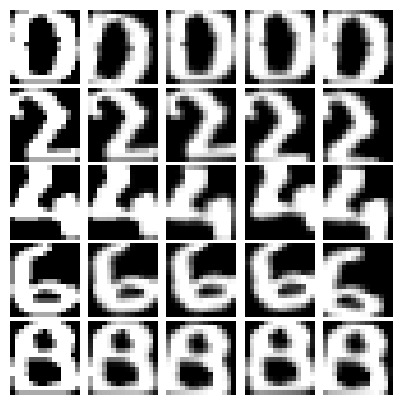

In [169]:

plot_sample_images_by_class(train_data_aug, num_classes=5, samples_per_class=5, img_shape=(16, 15), save_path="../visualizations/dataset_augmented_visualization.pdf")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Plot saved as tsne_plot_discrete_labels.pdf


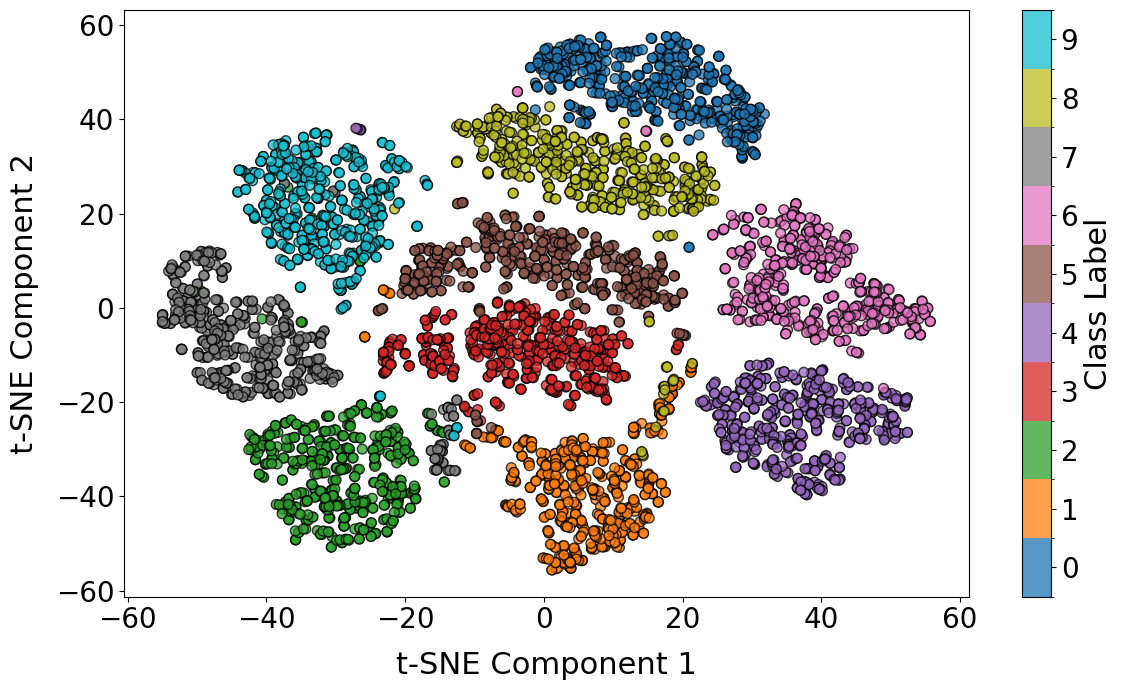

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("tab10")  
norm = BoundaryNorm(np.arange(-0.5, 10.5, 1), cmap.N)  

tsne = TSNE(n_components=2, perplexity=30, n_iter=500, learning_rate=300, random_state=42)
train_data_2D = tsne.fit_transform(train_data_aug)

plt.figure(figsize=(12, 7))  

scatter = plt.scatter(
    train_data_2D[:, 0], train_data_2D[:, 1], 
    c=train_labels, cmap=cmap, norm=norm, alpha=0.75, s=50, edgecolors="black"
)

cbar = plt.colorbar(scatter, ticks=np.arange(10)) 
cbar.set_label("Class Label", fontsize=22)
cbar.set_ticks(np.arange(10))  
cbar.set_ticklabels([str(i) for i in range(10)])  
cbar.ax.tick_params(labelsize=20)  

plt.xlabel("t-SNE Component 1", fontsize=22, labelpad=12)
plt.ylabel("t-SNE Component 2", fontsize=22, labelpad=12)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(False)

plt.tight_layout()

save_path = "tsne_plot_discrete_labels.pdf"
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')
print(f"Plot saved as {save_path}")

plt.show()

plt.close()